# Variant	Calling	for	Clonal	Haematopoiesis	of	Indeterminate	Potential	(CHIP)

*Classfy samples as CHIP positive or negative from Monash's ASPREE study* 

**Team Members**: Nick, Poornisha, Macey, Sam and Johnny

## 1. Introduction
Within the study, we have to classfy each sample as whether they contain CHIP and discover feature importance

## 2. Import Libraries
Import important libraries for preliminary data cleaning and formatting

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/chipVariantCalling_run1.tsv", sep='\t')
genes = df.SYMBOL.unique()
df

,d.barcode,DP,VD,AF,HIAF,IMPACT,SYMBOL,loci,sampleTimePt,gender,MSID,BIAS,REFBIAS,VARBIAS,QUAL,ODDRATIO,chipOrControl
0,4010289633,7281,26,0.0036,0.0033,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.0,1.182210,CHIP
1,4010289633,7281,26,0.0036,0.0033,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.0,1.182210,CHIP
2,4010289633,7281,26,0.0036,0.0033,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.0,1.182210,CHIP
3,4010289633,7281,26,0.0036,0.0033,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.0,1.182210,CHIP
4,4010289633,7282,29,0.0040,0.0036,MODERATE,GNB1,chr1:1747250_T/C,Baseline,Male,MS2083,2:2,3639:3606,15:14,32.7,1.061729,CHIP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137944,4010290016,731,2,0.0027,0.0028,MODERATE,ZFY,chrY:2848011_C/T,Blank,Blank,NaN,2:2,371:357,1:1,31.0,1.039170,NaN
1137945,4010290016,731,2,0.0027,0.0028,MODERATE,ZFY,chrY:2848029_C/T,Blank,Blank,NaN,2:2,367:359,1:1,37.0,1.022260,NaN
1137946,4010290016,731,2,0.0027,0.0028,MODERATE,ZFY,chrY:2848029_C/T,Blank,Blank,NaN,2:2,367:359,1:1,37.0,1.022260,NaN
1137947,4010290016,731,2,0.0027,0.0028,MODERATE,ZFY,chrY:2848029_C/T,Blank,Blank,NaN,2:2,367:359,1:1,37.0,1.022260,NaN


## 3. Data Editing

### Removing Variables
Drop columns and rows which are not relevant:
- "Blank" and "Control" are not required within training and testing
- Drop N/A values within `chipOrControl`
- Drop identifier columns and timeline

In [3]:
df = df[(df.chipOrControl != "Blank") & (df.chipOrControl != "Unknown")]
df = df.dropna(subset=['chipOrControl'])
df.drop(['MSID', 'd.barcode', 'sampleTimePt'], axis=1, inplace=True)

### Data-type Conversion
Currently, the columns: `BIAS`, `REFBIAS` and `VARBIAS` are strings. Change to floats such that it is not interpreted as catagorical data.

In [4]:
def ratio_to_int(string):
    a, b = string.split(":")
    if int(b) == 0:
        return 0
    else:
        return int(a) / int(b)

In [5]:
refbias = []
varbias = []

for ratio in df.REFBIAS.array:
    refbias.append(ratio_to_int(ratio)) 

for ratio in df.VARBIAS.array:
    varbias.append(ratio_to_int(ratio)) 

df['REFBIAS'] = pd.Series(refbias).values
df['VARBIAS'] = pd.Series(varbias).values

Separate `loci` into three separate columns: `chromosome` | `chromosome_location` | `nucleotide`

In [6]:
import re

chromosome = []
chromosome_location = []
nucleotide = []

for location_string in df.loci.array:
    separated = re.split(r"[:_]+", location_string)
    chromosome.append(separated[0])
    chromosome_location.append(separated[1])
    nucleotide.append(separated[2])

In [7]:
df['chromosome'] = pd.Series(chromosome).values
df['chromosome_loc'] = pd.Series(chromosome_location).values
df['nucleotide'] = pd.Series(nucleotide).values

df.drop(['loci'],axis=1, inplace=True)

One hot encode object types into numerics

In [8]:
objs = {}
lst = []
for i in df.columns:
    if df.dtypes[i] == object:
        print(len(df[f"{i}"].unique()), f"unique values for: {i}")
        if len(df[f"{i}"].unique()) <= 100:
            objs[i] = len(df[f"{i}"].unique())
            lst.append(i)

2 unique values for: IMPACT
40 unique values for: SYMBOL
2 unique values for: gender
8 unique values for: BIAS
2 unique values for: chipOrControl
18 unique values for: chromosome
9284 unique values for: chromosome_loc
202 unique values for: nucleotide


In [9]:
for i in lst:
    k = i
    dict = {}
    df_new = df
    for ix, i in zip(range(len(df_new[i].unique())), df_new[i].unique() ):
        dict[i] = ix
    df = df.replace({f"{k}": dict})
    df[f"{k}"] = df[f"{k}"].astype(str).astype(float)

In [10]:
for i in df.columns:
    if df.dtypes[i] == float:
        print(len(df[f"{i}"].unique()), f"unique values for: {i}")

903 unique values for: AF
872 unique values for: HIAF
2 unique values for: IMPACT
40 unique values for: SYMBOL
2 unique values for: gender
8 unique values for: BIAS
43820 unique values for: REFBIAS
2494 unique values for: VARBIAS
146 unique values for: QUAL
26364 unique values for: ODDRATIO
2 unique values for: chipOrControl
18 unique values for: chromosome


Drop chromosome location (if required)

In [11]:
df.drop(['chromosome', 'chromosome_loc', 'nucleotide'], axis=1, inplace=True)

In [12]:
df

,DP,VD,AF,HIAF,IMPACT,SYMBOL,gender,BIAS,REFBIAS,VARBIAS,QUAL,ODDRATIO,chipOrControl
0,7281,26,0.0036,0.0033,0.0,0.0,0.0,0.0,1.013348,0.857143,34.0,1.182210,0.0
1,7281,26,0.0036,0.0033,0.0,0.0,0.0,0.0,1.013348,0.857143,34.0,1.182210,0.0
2,7281,26,0.0036,0.0033,0.0,0.0,0.0,0.0,1.013348,0.857143,34.0,1.182210,0.0
3,7281,26,0.0036,0.0033,0.0,0.0,0.0,0.0,1.013348,0.857143,34.0,1.182210,0.0
4,7282,29,0.0040,0.0036,0.0,0.0,0.0,0.0,1.009151,1.071429,32.7,1.061729,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
536743,711,2,0.0028,0.0028,0.0,28.0,1.0,0.0,1.008499,1.000000,25.0,1.008490,1.0
536744,711,2,0.0028,0.0028,0.0,28.0,1.0,0.0,1.008499,1.000000,25.0,1.008490,1.0
536745,711,2,0.0028,0.0028,0.0,28.0,1.0,0.0,1.008499,1.000000,25.0,1.008490,1.0
536746,711,2,0.0028,0.0028,0.0,28.0,1.0,0.0,1.008499,1.000000,25.0,1.008490,1.0


### ONE HOT ENCODE "SYMBOL" with pd.get_dummies()

In [13]:
df_model = df
df_model = pd.concat([df_model,pd.get_dummies(df_model['SYMBOL'], prefix='GENE')],axis=1)
df_model.drop(['SYMBOL'],axis=1, inplace=True)

In [14]:
df_model

,DP,VD,AF,HIAF,IMPACT,gender,BIAS,REFBIAS,VARBIAS,QUAL,...,GENE_30.0,GENE_31.0,GENE_32.0,GENE_33.0,GENE_34.0,GENE_35.0,GENE_36.0,GENE_37.0,GENE_38.0,GENE_39.0
0,7281,26,0.0036,0.0033,0.0,0.0,0.0,1.013348,0.857143,34.0,...,0,0,0,0,0,0,0,0,0,0
1,7281,26,0.0036,0.0033,0.0,0.0,0.0,1.013348,0.857143,34.0,...,0,0,0,0,0,0,0,0,0,0
2,7281,26,0.0036,0.0033,0.0,0.0,0.0,1.013348,0.857143,34.0,...,0,0,0,0,0,0,0,0,0,0
3,7281,26,0.0036,0.0033,0.0,0.0,0.0,1.013348,0.857143,34.0,...,0,0,0,0,0,0,0,0,0,0
4,7282,29,0.0040,0.0036,0.0,0.0,0.0,1.009151,1.071429,32.7,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536743,711,2,0.0028,0.0028,0.0,1.0,0.0,1.008499,1.000000,25.0,...,0,0,0,0,0,0,0,0,0,0
536744,711,2,0.0028,0.0028,0.0,1.0,0.0,1.008499,1.000000,25.0,...,0,0,0,0,0,0,0,0,0,0
536745,711,2,0.0028,0.0028,0.0,1.0,0.0,1.008499,1.000000,25.0,...,0,0,0,0,0,0,0,0,0,0
536746,711,2,0.0028,0.0028,0.0,1.0,0.0,1.008499,1.000000,25.0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df_model.columns[12:]

Index(['GENE_0.0', 'GENE_1.0', 'GENE_2.0', 'GENE_3.0', 'GENE_4.0', 'GENE_5.0',
       'GENE_6.0', 'GENE_7.0', 'GENE_8.0', 'GENE_9.0', 'GENE_10.0',
       'GENE_11.0', 'GENE_12.0', 'GENE_13.0', 'GENE_14.0', 'GENE_15.0',
       'GENE_16.0', 'GENE_17.0', 'GENE_18.0', 'GENE_19.0', 'GENE_20.0',
       'GENE_21.0', 'GENE_22.0', 'GENE_23.0', 'GENE_24.0', 'GENE_25.0',
       'GENE_26.0', 'GENE_27.0', 'GENE_28.0', 'GENE_29.0', 'GENE_30.0',
       'GENE_31.0', 'GENE_32.0', 'GENE_33.0', 'GENE_34.0', 'GENE_35.0',
       'GENE_36.0', 'GENE_37.0', 'GENE_38.0', 'GENE_39.0'],
      dtype='object')

In [16]:
dummy_genes = df_model.columns[12:]

In [17]:
d = {}

for i in range(len(dummy_genes)):
    d[dummy_genes[i]] = genes[i]

In [18]:
df_model = df_model.rename(d, axis=1)  # new method

In [19]:
df_model

,DP,VD,AF,HIAF,IMPACT,gender,BIAS,REFBIAS,VARBIAS,QUAL,...,ZFY,AMELY,LY9,SYNE1,AC078842.3,NOTCH1,IDH2,SRSF2,RP11-661A12.9,TLK2
0,7281,26,0.0036,0.0033,0.0,0.0,0.0,1.013348,0.857143,34.0,...,0,0,0,0,0,0,0,0,0,0
1,7281,26,0.0036,0.0033,0.0,0.0,0.0,1.013348,0.857143,34.0,...,0,0,0,0,0,0,0,0,0,0
2,7281,26,0.0036,0.0033,0.0,0.0,0.0,1.013348,0.857143,34.0,...,0,0,0,0,0,0,0,0,0,0
3,7281,26,0.0036,0.0033,0.0,0.0,0.0,1.013348,0.857143,34.0,...,0,0,0,0,0,0,0,0,0,0
4,7282,29,0.0040,0.0036,0.0,0.0,0.0,1.009151,1.071429,32.7,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536743,711,2,0.0028,0.0028,0.0,1.0,0.0,1.008499,1.000000,25.0,...,0,0,0,0,0,0,0,0,0,0
536744,711,2,0.0028,0.0028,0.0,1.0,0.0,1.008499,1.000000,25.0,...,0,0,0,0,0,0,0,0,0,0
536745,711,2,0.0028,0.0028,0.0,1.0,0.0,1.008499,1.000000,25.0,...,0,0,0,0,0,0,0,0,0,0
536746,711,2,0.0028,0.0028,0.0,1.0,0.0,1.008499,1.000000,25.0,...,0,0,0,0,0,0,0,0,0,0


# Random Forests

In [20]:
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression # import the LogisticRegression model

import warnings
warnings.filterwarnings('ignore') # suppress warnings

In [21]:
from logitplots import plt_confusion_matrix, plt_decision_boundaries, plt_correlation_matrix

In [22]:
X = df_model.drop('chipOrControl', axis = 1) # drop the target variable for the features
y = df_model['chipOrControl'] # create a target dataframe
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=0)
# instantatiate the RFC with 100 ensemble members
clf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
Y_pred = clf.predict(X_test)  # calculate the predicted values

In [23]:
# print the accuracy of the RFC
print('Accuracy {0}'.format(np.round(accuracy_score(y_test, Y_pred),3)))
# loop over all the names and feature importance and print both
for name, score in zip(X.columns, clf.feature_importances_):
    print(name,np.round(score,3))

Accuracy 0.978
DP 0.223
VD 0.05
AF 0.102
HIAF 0.106
IMPACT 0.008
gender 0.019
BIAS 0.003
REFBIAS 0.162
VARBIAS 0.026
QUAL 0.053
ODDRATIO 0.153
GNB1 0.001
NRAS 0.001
NOTCH2 0.001
DNMT3A 0.013
ASXL2 0.001
CERKL 0.0
SF3B1 0.003
TET2 0.015
SNX18 0.001
BRAF 0.003
RAD21 0.004
JAK2 0.001
TET1 0.0
CBL 0.002
KRAS 0.002
PTPN11 0.001
CREBBP 0.004
TP53 0.007
DNAH2 0.001
PPM1D 0.004
ASXL1 0.008
CHMP4B 0.001
GNAS 0.003
LIPI 0.0
U2AF1 0.003
ZFX 0.0
BCOR 0.005
BCORL1 0.004
BRCC3 0.005
SRY 0.001
ZFY 0.0
AMELY 0.0
LY9 0.0
SYNE1 0.0
AC078842.3 0.0
NOTCH1 0.0
IDH2 0.001
SRSF2 0.0
RP11-661A12.9 0.0
TLK2 0.0


# Decision Tree

In [24]:
# Instantatiate the DTC
df_dtc = DecisionTreeClassifier(random_state = 42, max_depth = 3)
df_dtc = df_dtc.fit(X_train, y_train) # training

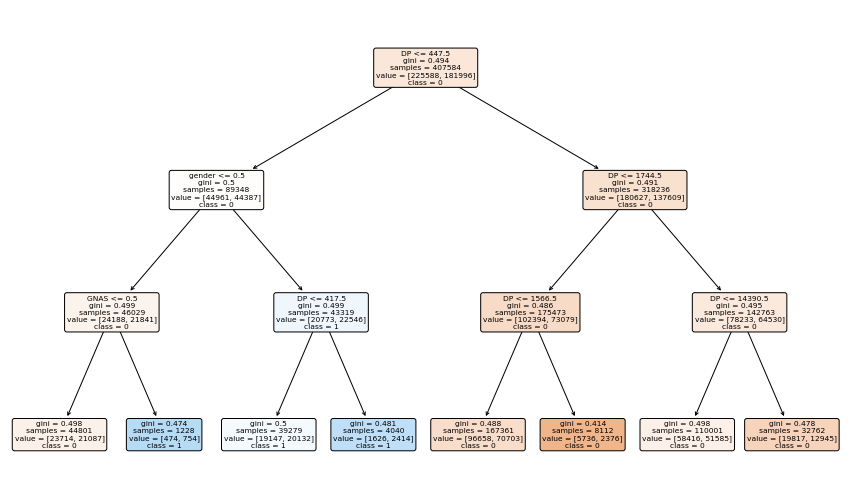

In [25]:
classes = ['0', '1']

fig, ax = plt.subplots(figsize=(15,9)) # initialise the plots and axes
# plot the decision tree for the model df_dtc
plot_tree(df_dtc, 
 filled = True, # colour the nodes according to the classifaction
 rounded = True, # make the nodes have rounded corners
 class_names = classes, # use these names for targets
 feature_names = X.columns # use these names for features
 );

Decision Tree Accuracy: 0.558


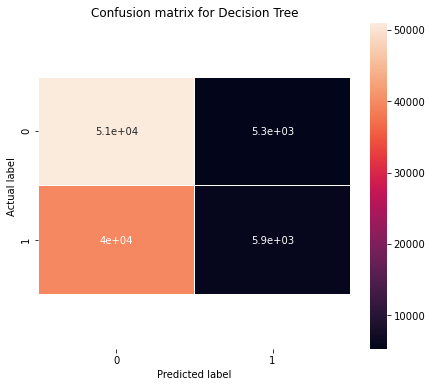

In [26]:
Y_pred = df_dtc.predict(X_test) # calculate the predictions of the model for our test set
# plot the confusion matrix for the test and predicted target values
cm = confusion_matrix(y_test, Y_pred)
plt_confusion_matrix(cm, classes, 'Decision Tree') 
print("Decision Tree Accuracy:",np.round(accuracy_score(y_test, Y_pred),3)) # calculate and print the accuracy score

In [27]:
# Instantatiate the DTC
for i in range(1,8):
    df_dtc = DecisionTreeClassifier(random_state = 42, max_depth = i)
    df_dtc = df_dtc.fit(X_train, y_train) # training
    Y_pred = df_dtc.predict(X_test) # calculate the predicted values
    accuracy = np.round(accuracy_score(y_test, Y_pred),3) # calculate the accuracy score
    print("Depth, Accuracy = ", f"{i}, {accuracy}")

Depth, Accuracy =  1, 0.553
Depth, Accuracy =  2, 0.558
Depth, Accuracy =  3, 0.558
Depth, Accuracy =  4, 0.56
Depth, Accuracy =  5, 0.563
Depth, Accuracy =  6, 0.566
Depth, Accuracy =  7, 0.57


If depth increases, overfitting will become too overbearing

# Logistic Regression

In [3]:
df_1 = pd.read_csv('chipVariantCalling_run1.tsv', sep = '\t')
df_2 = pd.read_csv('chipVariantCalling_run2.tsv', sep = '\t', low_memory=False)

known1 = df_1[df_1['chipOrControl'].isin(['CHIP', 'Control'])]
df1 = known1.drop_duplicates()
df1 = df1.rename(columns={"d.barcode": "barcode"})

known2 = df_2[df_2['chipOrControl'].isin(['CHIP', 'Control'])]
df2 = known2.drop_duplicates()
df2 = df2.rename(columns={"d.barcode": "barcode"})

In [4]:
#Making binary 
df1['gender']=df1.gender.astype(object)
df1['chipOrControl']=df1.chipOrControl.astype(object)
df1['sampleTimePt']=df1.sampleTimePt.astype(object)

df1 = df1.replace({'gender': {'Male': 1, 'Female': 0}})

df1 = df1.replace({'sampleTimePt': {'Baseline': 1, 'Y3': 0}})

df1 = df1.replace({'chipOrControl': {'CHIP': 1, 'Control': 0}})

dfg1 = df1[['chipOrControl', 'SYMBOL', 'AF', 'ODDRATIO', 'VD']]
df_chip1 = dfg1[dfg1["AF"] >= 0.02]
control_1 = df_chip1[df_chip1['chipOrControl'] == 0]
print(df_chip1.count())
print(control_1.count())
print(control_1.count()/df_chip1.count())

chipOrControl    3623
SYMBOL           3623
AF               3623
ODDRATIO         3623
VD               3623
dtype: int64
chipOrControl    1682
SYMBOL           1682
AF               1682
ODDRATIO         1682
VD               1682
dtype: int64
chipOrControl    0.464256
SYMBOL           0.464256
AF               0.464256
ODDRATIO         0.464256
VD               0.464256
dtype: float64


In [5]:
df2['gender']=df2.gender.astype(object)
df2['chipOrControl']=df2.chipOrControl.astype(object)
df2['sampleTimePt']=df2.sampleTimePt.astype(object)

df2 = df2.replace({'gender': {'Male': 1, 'Female': 0}})

df2 = df2.replace({'sampleTimePt': {'Baseline': 1, 'Y3': 0}})

df2 = df2.replace({'chipOrControl': {'CHIP': 1, 'Control': 0}})

dfg2 = df2[['chipOrControl', 'SYMBOL', 'AF', 'ODDRATIO', 'VD']]
df_chip2 = dfg2[dfg2["AF"] >= 0.02]
control_2 = df_chip2[df_chip2['chipOrControl'] == 0]
print(df_chip2.count())
print(control_2.count())
print(control_2.count()/df_chip2.count())

chipOrControl    9328
SYMBOL           9328
AF               9328
ODDRATIO         9328
VD               9328
dtype: int64
chipOrControl    4450
SYMBOL           4450
AF               4450
ODDRATIO         4450
VD               4450
dtype: int64
chipOrControl    0.477058
SYMBOL           0.477058
AF               0.477058
ODDRATIO         0.477058
VD               0.477058
dtype: float64


In [6]:
X = df_chip1.drop(['chipOrControl', 'SYMBOL'],axis=1) # drop Y from our dataframe
y = df_chip1['chipOrControl'] # create a dataframe with just the Y values

X = (X-X.mean())/X.std()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.8, random_state=1) 

from sklearn.linear_model import LogisticRegression # import the LogisticRegression model

logreg = LogisticRegression(solver='lbfgs',penalty='none')
logreg.fit(X_train,y_train) # fit the training data to the model
print('Model coefficients are',np.round(logreg.coef_,3)) # print the model coefficients c1,...,c4
print('Model intercept is',np.round(logreg.intercept_,3)) # print the model intercept c0

Model coefficients are [[-0.037  0.127  0.016]]
Model intercept is [0.009]


Probability table for testing set is:
[[0.50115408 0.49884592]
 [0.49401937 0.50598063]
 [0.49373196 0.50626804]
 ...
 [0.49393156 0.50606844]
 [0.49797261 0.50202739]
 [0.49374987 0.50625013]]


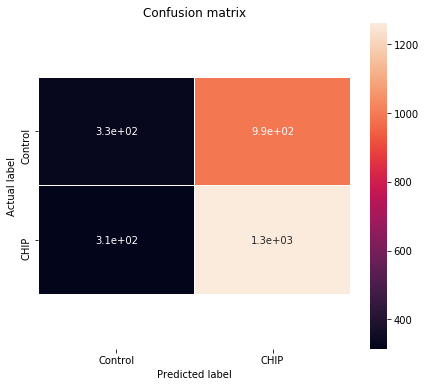

In [7]:
 y_preda = logreg.predict_proba(X_test) # calculate the probabilities for the test features
# print out the probability table with a header
print('Probability table for testing set is:')
print(y_preda)

y_pred=logreg.predict(X_test)

 from sklearn.metrics import confusion_matrix # import the confusion matrix function
cnf_matrix = confusion_matrix(y_test, y_pred) # create a confusion matrix for our actual and predicted values
# create a data frame from the confusion matrix with the column and row names being the class_names
class_names=['Control', 'CHIP'] # names of the binary classes for plotting
cmatrix = pd.DataFrame(cnf_matrix,columns=class_names,index=class_names) 
f, ax = plt.subplots(figsize=(7,6)) # initialise the plots and axes
sns.heatmap(cmatrix, annot=True, linewidths=.5) # plot the confusion matrix as a heatmap
plt.title('Confusion matrix') # add a title
plt.ylabel('Actual label') # add a ylabel
plt.xlabel('Predicted label') # add a xlabel
# adjust the bottom and top of the figure, so we can view all of it
bottom, top = ax.get_ylim()  # get the y axis limits
ax.set_ylim(bottom + 0.5, top - 0.5); # adjust the y axis limits

Accuracy: 0.549
Precision: 0.56
Recall: 0.801


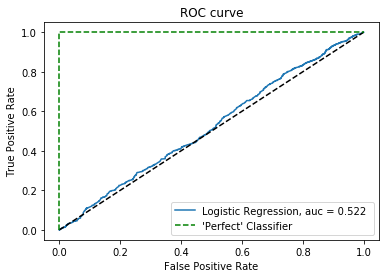

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score # import the score functions 
print("Accuracy:",np.round(accuracy_score(y_test, y_pred),3)) # calculate and print the accuracy score
print("Precision:",np.round(precision_score(y_test, y_pred),3)) # calculate and print the precision score
print("Recall:",np.round(recall_score(y_test, y_pred),3)) # calculate and print the recall score


 # import the functions to calculate the parameters for the ROC curve and the AUC
from sklearn.metrics import roc_curve, roc_auc_score 
y_pred_proba = logreg.predict_proba(X_test)[::,1] # extract the second column of the model probabilities 
# calculate the false positive and true positive rates as the threshold is varied, we don't use thresholds
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba) # calculate the area under the ROC curve (AUC)
# plot the FPR vs TPR and format label with AUC to 3 decimal places
plt.plot(fpr,tpr,label="Logistic Regression, auc = %0.3f " % auc)
plt.plot([0,1],[0,1],'k--') # plot x = y for comparison
plt.plot([0, 0, 1], [0, 1, 1], 'g--', label="'Perfect' Classifier")
plt.xlabel('False Positive Rate') # add xlabel
plt.ylabel('True Positive Rate') # add ylabel
plt.title('ROC curve') # add title
plt.legend(loc='best'); # add legend

### Logistic regression with the full dataset (run1)

In [19]:
df1 = pd.read_csv("chipVariantCalling_run1.tsv", sep = '\t')
df1.head()

,d.barcode,DP,VD,AF,HIAF,IMPACT,SYMBOL,loci,sampleTimePt,gender,MSID,BIAS,REFBIAS,VARBIAS,QUAL,ODDRATIO,chipOrControl
0,4010289633,7281,26,0.0036,0.0033,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.0,1.182210,CHIP
1,4010289633,7281,26,0.0036,0.0033,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.0,1.182210,CHIP
2,4010289633,7281,26,0.0036,0.0033,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.0,1.182210,CHIP
3,4010289633,7281,26,0.0036,0.0033,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.0,1.182210,CHIP
4,4010289633,7282,29,0.0040,0.0036,MODERATE,GNB1,chr1:1747250_T/C,Baseline,Male,MS2083,2:2,3639:3606,15:14,32.7,1.061729,CHIP


In [20]:
df1 = df1[df1.chipOrControl != 'Blank']
df1 = df1[df1.chipOrControl != 'Unknown']
df1 = df1.drop_duplicates()
df1 = df1.dropna(subset=['chipOrControl'])

In [33]:
df1 = df1.replace({'chipOrControl': {'CHIP': 1, 'Control': 0}})

df1.head()

,d.barcode,DP,VD,AF,HIAF,IMPACT,SYMBOL,loci,sampleTimePt,gender,MSID,BIAS,REFBIAS,VARBIAS,QUAL,ODDRATIO,chipOrControl
0,4010289633,7281,26,0.0036,0.0033,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.0,1.182210,1
4,4010289633,7282,29,0.0040,0.0036,MODERATE,GNB1,chr1:1747250_T/C,Baseline,Male,MS2083,2:2,3639:3606,15:14,32.7,1.061729,1
8,4010289633,7282,24,0.0033,0.0033,MODERATE,GNB1,chr1:1747256_T/C,Baseline,Male,MS2083,2:2,3626:3607,12:12,34.9,1.005270,1
12,4010289633,178,2,0.0112,0.0120,MODERATE,NRAS,chr1:115256571_T/C,Baseline,Male,MS2083,2:2,88:88,1:1,37.0,1.000000,1
13,4010289633,1773,6,0.0034,0.0035,MODERATE,NRAS,chr1:115258674_T/C,Baseline,Male,MS2083,2:2,889:874,3:3,37.0,1.017150,1


#### With X variables as `DP`, `VD`, `AF` and `HIAF`

In [34]:
XX, Y = df1[df1.columns[1:5]], df1.chipOrControl
X = (XX-XX.mean())/XX.std() 
from sklearn.model_selection import train_test_split # import the splitting method from sklearn

# split the data into 80% training and 20% testing, random_state=0 ensures that the results are repeatable
X_train,X_test,y_train,y_test=train_test_split(X,Y,train_size=0.8,random_state=0)  

from sklearn.linear_model import LogisticRegression # import the LogisticRegression model
# instantiate the model (using the default parameters)
# penalty='none' implies no regularization and solver='lbfgs' is the default solver
# different solvers can be used, dependent on the type of penalties that are implemented
logreg = LogisticRegression(solver='lbfgs',penalty='none')
logreg.fit(X_train,y_train) # fit the training data to the model
print('Model coefficients are',np.round(logreg.coef_,3)) # print the model coefficients c1,...,c4
print('Model intercept is',np.round(logreg.intercept_,3)) # print the model intercept c0

y_preda = logreg.predict_proba(X_test) # calculate the probabilities for the test features
# print out the probability table with a header
print('Probability table for testing set is:')
print(y_preda)

Model coefficients are [[ 0.051 -0.004 -0.013 -0.013]]
Model intercept is [0.213]
Probability table for testing set is:
[[0.45241862 0.54758138]
 [0.45114666 0.54885334]
 [0.44986568 0.55013432]
 ...
 [0.45146679 0.54853321]
 [0.44768956 0.55231044]
 [0.45134627 0.54865373]]


Accuracy: 0.549
Precision: 0.55
Recall: 0.996


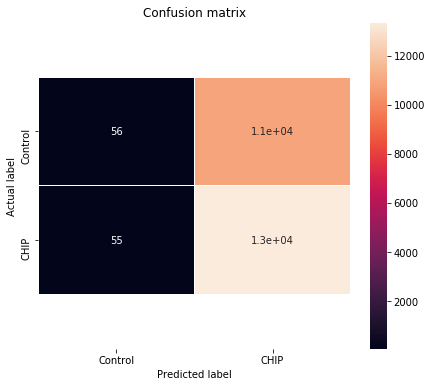

In [36]:
from sklearn.metrics import confusion_matrix # import the confusion matrix function
from sklearn.metrics import accuracy_score, precision_score, recall_score # import the score functions 

y_pred=logreg.predict(X_test) # calculate the predicted values of the model for the test features

cnf_matrix = confusion_matrix(y_test, y_pred) # create a confusion matrix for our actual and predicted values
# create a data frame from the confusion matrix with the column and row names being the class_names
class_names=['Control', 'CHIP'] # names of the binary classes for plotting
cmatrix = pd.DataFrame(cnf_matrix,columns=class_names,index=class_names) 
f, ax = plt.subplots(figsize=(7,6)) # initialise the plots and axes
sns.heatmap(cmatrix, annot=True, linewidths=.5) # plot the confusion matrix as a heatmap
plt.title('Confusion matrix') # add a title
plt.ylabel('Actual label') # add a ylabel
plt.xlabel('Predicted label') # add a xlabel
# adjust the bottom and top of the figure, so we can view all of it
bottom, top = ax.get_ylim()  # get the y axis limits
ax.set_ylim(bottom + 0.5, top - 0.5); # adjust the y axis limits

print("Accuracy:",np.round(accuracy_score(y_test, y_pred),3)) # calculate and print the accuracy score
print("Precision:",np.round(precision_score(y_test, y_pred),3)) # calculate and print the precision score
print("Recall:",np.round(recall_score(y_test, y_pred),3)) # calculate and print the recall score

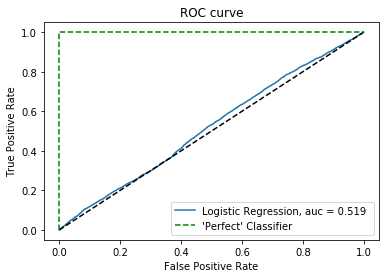

In [38]:
# import the functions to calculate the parameters for the ROC curve and the AUC
from sklearn.metrics import roc_curve, roc_auc_score 
y_pred_proba = logreg.predict_proba(X_test)[::,1] # extract the second column of the model probabilities 
# calculate the false positive and true positive rates as the threshold is varied, we don't use thresholds
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba) # calculate the area under the ROC curve (AUC)
# plot the FPR vs TPR and format label with AUC to 3 decimal places
plt.plot(fpr,tpr,label="Logistic Regression, auc = %0.3f " % auc)
plt.plot([0,1],[0,1],'k--') # plot x = y for comparison
plt.plot([0, 0, 1], [0, 1, 1], 'g--', label="'Perfect' Classifier")
plt.xlabel('False Positive Rate') # add xlabel
plt.ylabel('True Positive Rate') # add ylabel
plt.title('ROC curve') # add title
plt.legend(loc='best'); # add legend

### REFBIAS WITH THE FIRST DATASET

In [2]:
df1 = pd.read_csv("chipVariantCalling_run1.tsv", sep = '\t')
df1.head()

,d.barcode,DP,VD,AF,HIAF,IMPACT,SYMBOL,loci,sampleTimePt,gender,MSID,BIAS,REFBIAS,VARBIAS,QUAL,ODDRATIO,chipOrControl
0,4010289633,7281,26,0.0036,0.0033,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.0,1.182210,CHIP
1,4010289633,7281,26,0.0036,0.0033,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.0,1.182210,CHIP
2,4010289633,7281,26,0.0036,0.0033,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.0,1.182210,CHIP
3,4010289633,7281,26,0.0036,0.0033,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.0,1.182210,CHIP
4,4010289633,7282,29,0.0040,0.0036,MODERATE,GNB1,chr1:1747250_T/C,Baseline,Male,MS2083,2:2,3639:3606,15:14,32.7,1.061729,CHIP


In [3]:
#drop unnecessary columns
df1 = df1[df1.chipOrControl != 'Blank']
df1 = df1[df1.chipOrControl != 'Unknown']
df1 = df1.drop_duplicates()
df1 = df1.dropna(subset=['chipOrControl'])
df1.drop(['d.barcode', 'IMPACT', 'gender'], axis=1, inplace=True)

In [4]:
df1 = df1.replace({'chipOrControl': {'CHIP': 1, 'Control': 0}})

df1.head()

,DP,VD,AF,HIAF,SYMBOL,loci,sampleTimePt,MSID,BIAS,REFBIAS,VARBIAS,QUAL,ODDRATIO,chipOrControl
0,7281,26,0.0036,0.0033,GNB1,chr1:1747196_T/C,Baseline,MS2083,2:2,3644:3596,12:14,34.0,1.182210,1
4,7282,29,0.0040,0.0036,GNB1,chr1:1747250_T/C,Baseline,MS2083,2:2,3639:3606,15:14,32.7,1.061729,1
8,7282,24,0.0033,0.0033,GNB1,chr1:1747256_T/C,Baseline,MS2083,2:2,3626:3607,12:12,34.9,1.005270,1
12,178,2,0.0112,0.0120,NRAS,chr1:115256571_T/C,Baseline,MS2083,2:2,88:88,1:1,37.0,1.000000,1
13,1773,6,0.0034,0.0035,NRAS,chr1:115258674_T/C,Baseline,MS2083,2:2,889:874,3:3,37.0,1.017150,1


In [5]:
#converting reference bias and variable bias to float types
def ratio_to_int(string):
    a, b = string.split(":")
    if int(b) == 0:
        return 0
    else:
        return int(a) / int(b)

refbias = []
varbias = []

for ratio in df1.REFBIAS.array:
    refbias.append(ratio_to_int(str(ratio))) 

for ratio in df1.VARBIAS.array:
    varbias.append(ratio_to_int(str(ratio))) 
    
refbias = pd.Series(refbias)
varbias = pd.Series(varbias)

df1['REFBIAS'] = refbias.values
df1['VARBIAS'] = varbias.values

In [6]:
df1

,DP,VD,AF,HIAF,SYMBOL,loci,sampleTimePt,MSID,BIAS,REFBIAS,VARBIAS,QUAL,ODDRATIO,chipOrControl
0,7281,26,0.0036,0.0033,GNB1,chr1:1747196_T/C,Baseline,MS2083,2:2,1.013348,0.857143,34.0,1.182210,1
4,7282,29,0.0040,0.0036,GNB1,chr1:1747250_T/C,Baseline,MS2083,2:2,1.009151,1.071429,32.7,1.061729,1
8,7282,24,0.0033,0.0033,GNB1,chr1:1747256_T/C,Baseline,MS2083,2:2,1.005268,1.000000,34.9,1.005270,1
12,178,2,0.0112,0.0120,NRAS,chr1:115256571_T/C,Baseline,MS2083,2:2,1.000000,1.000000,37.0,1.000000,1
13,1773,6,0.0034,0.0035,NRAS,chr1:115258674_T/C,Baseline,MS2083,2:2,1.017162,1.000000,37.0,1.017150,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536725,711,2,0.0028,0.0028,BRCC3,chrX:154305513_C/T,Y3,MS6625,2:2,1.008499,1.000000,31.0,1.008490,0
536726,711,2,0.0028,0.0029,BRCC3,chrX:154305518_T/C,Y3,MS6625,2:2,1.005666,1.000000,37.0,1.005660,0
536733,711,2,0.0028,0.0029,BRCC3,chrX:154305518_T/C,Y3,MS6625,2:2,1.005666,1.000000,37.0,1.005660,0
536734,711,2,0.0028,0.0029,BRCC3,chrX:154305533_A/T,Y3,MS6625,2:2,1.008499,1.000000,37.0,1.008490,0


Twp different dataframes:

`actual_chip` - contains all the values with `AF`>= 0.02 (by contemporary definition) and are classified as CHIP

`false_control` - contains all the values with `AF`>= 0.02 but are classified as Control

In [7]:
allele_fq = df1[df1["AF"] >= 0.02]
actual_chip = allele_fq[allele_fq["chipOrControl"] == 1]
false_control = allele_fq[allele_fq["chipOrControl"] == 0]
actual_chip

,DP,VD,AF,HIAF,SYMBOL,loci,sampleTimePt,MSID,BIAS,REFBIAS,VARBIAS,QUAL,ODDRATIO,chipOrControl
276,80,2,0.0250,0.0260,DNMT3A,chr2:25467154_G/A,Baseline,MS2083,2:2,1.166667,1.000000,37.0,1.164410,1
716,4201,2113,0.5030,0.5025,TET2,chr4:106155620_C/A,Baseline,MS2083,2:2,1.010628,1.018147,35.8,1.007435,1
1332,2,2,1.0000,1.0000,TET2,chr4:106157527_C/T,Baseline,MS2083,0:2,0.000000,1.000000,31.0,0.000000,1
1444,50,3,0.0600,0.0435,TET2,chr4:106158252_G/T,Baseline,MS2083,2:2,1.043478,0.500000,28.3,2.057400,1
1452,51,2,0.0392,0.0417,TET2,chr4:106158331_A/G,Baseline,MS2083,2:2,0.960000,1.000000,37.0,1.040843,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526423,96274,47654,0.4950,0.4966,SNX18,chr5:53815495_A/C,Y3,MS14472,2:2,1.015994,1.012586,36.2,1.003370,1
526738,1681,1668,0.9923,0.9958,TP53,chr17:7579472_G/C,Y3,MS14472,2:2,1.000000,1.016929,36.3,1.016922,1
526776,53,2,0.0377,0.0385,SRSF2,chr17:74733034_T/C,Y3,MS14472,2:2,1.040000,1.000000,37.0,1.039240,1
526835,25218,24992,0.9910,0.9959,ASXL1,chr20:31022959_T/C,Y3,MS14472,2:2,1.000000,1.015809,35.8,1.015806,1


In [8]:
false_control

,DP,VD,AF,HIAF,SYMBOL,loci,sampleTimePt,MSID,BIAS,REFBIAS,VARBIAS,QUAL,ODDRATIO,chipOrControl
11953,18320,516,0.0282,0.0286,DNMT3A,chr2:25457256_GACGTC/G,Baseline,MS14128,2:2,1.012819,1.015625,36.9,1.002768,0
12213,144,4,0.0278,0.0280,DNMT3A,chr2:25464507_G/A,Baseline,MS14128,2:2,1.028986,1.000000,37.0,1.028790,0
12303,16,2,0.1250,0.1250,DNMT3A,chr2:25468147_A/G,Baseline,MS14128,2:2,1.000000,1.000000,31.0,1.000000,0
12775,408,215,0.5270,0.5179,TET2,chr4:106155751_G/A,Baseline,MS14128,2:2,1.010526,1.067308,34.6,1.056022,0
13759,163,4,0.0245,0.0191,TET2,chr4:106157812_G/A,Baseline,MS14128,2:2,0.987342,1.000000,27.5,1.012740,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536378,179,4,0.0223,0.0227,ASXL1,chr20:31022811_T/C,Y3,MS6625,2:2,1.011494,1.000000,37.0,1.011430,0
536382,6820,6749,0.9896,0.9962,ASXL1,chr20:31022959_T/C,Y3,MS6625,2:2,1.000000,1.020054,35.7,1.020054,0
536400,178,4,0.0225,0.0225,ASXL1,chr20:31023305_G/A,Y3,MS6625,2:2,1.000000,1.000000,37.0,1.000000,0
536482,53257,26575,0.4990,0.4976,LIPI,chr21:15481365_G/T,Y3,MS6625,2:2,1.011299,1.011277,35.5,1.000000,0


In [9]:
print("ACTUAL_CHIP DESCRIPTION")
print(" ")
print(actual_chip.describe())
print(" ")
print("FALSE_CONTROL DESCRIPTION")
print(" ")
print(false_control.describe())

ACTUAL_CHIP DESCRIPTION
 
                  DP             VD           AF         HIAF      REFBIAS  \
count    1941.000000    1941.000000  1941.000000  1941.000000  1941.000000   
mean     5730.137043    3782.135497     0.197759     0.199533     1.098606   
std     22055.169437   16979.919135     0.312914     0.314402     3.740221   
min         2.000000       2.000000     0.020000     0.013900     0.000000   
25%        50.000000       2.000000     0.025000     0.025300     1.000000   
50%        89.000000       2.000000     0.040800     0.041700     1.000000   
75%       250.000000       9.000000     0.142900     0.150200     1.030303   
max    324189.000000  319533.000000     1.000000     1.000000   104.666667   

           VARBIAS         QUAL      ODDRATIO  chipOrControl  
count  1941.000000  1941.000000   1941.000000         1941.0  
mean      1.386735    35.952550      8.543060            1.0  
std      16.476665     2.157903    324.243488            0.0  
min       0.000000 

### INVESTIGATING REFBIAS WITH THE SECOND DATASET

In [10]:
df2 = pd.read_csv("chipVariantCalling_run2.tsv", sep = '\t', low_memory = False)
df2.head()

,d.barcode,DP,VD,AF,HIAF,IMPACT,SYMBOL,loci,sampleTimePt,gender,MSID,BIAS,REFBIAS,VARBIAS,QUAL,ODDRATIO,chipOrControl
0,4010289633,2036,6,0.0029,0.0044,HIGH,GNB1,chr1:1747193_A/G,Baseline,Male,MS2083,2:2,940:982,3:3,35.0,1.04467,CHIP
1,4010289633,2036,6,0.0029,0.0044,HIGH,GNB1,chr1:1747193_A/G,Baseline,Male,MS2083,2:2,940:982,3:3,35.0,1.04467,CHIP
2,4010289633,2036,6,0.0029,0.0044,HIGH,GNB1,chr1:1747193_A/G,Baseline,Male,MS2083,2:2,940:982,3:3,35.0,1.04467,CHIP
3,4010289633,2036,6,0.0029,0.0044,HIGH,GNB1,chr1:1747193_A/G,Baseline,Male,MS2083,2:2,940:982,3:3,35.0,1.04467,CHIP
4,4010289633,2036,6,0.0029,0.0044,HIGH,GNB1,chr1:1747193_A/G,Baseline,Male,MS2083,2:2,940:982,3:3,35.0,1.04467,CHIP


In [11]:
#drop unnecessary columns
df2 = df2[df2.chipOrControl != 'Blank']
df2 = df2[df2.chipOrControl != 'Unknown']
df2 = df2.drop_duplicates()
df2 = df2.dropna(subset=['chipOrControl'])
df2.drop(['d.barcode', 'IMPACT', 'gender'], axis=1, inplace=True)

In [12]:
df2 = df2.replace({'chipOrControl': {'CHIP': 1, 'Control': 0}})

df2.head()

,DP,VD,AF,HIAF,SYMBOL,loci,sampleTimePt,MSID,BIAS,REFBIAS,VARBIAS,QUAL,ODDRATIO,chipOrControl
0,2036,6,0.0029,0.0044,GNB1,chr1:1747193_A/G,Baseline,MS2083,2:2,940:982,3:3,35.0,1.04467,1
5,2036,7,0.0034,0.0035,GNB1,chr1:1747198_G/A,Baseline,MS2083,2:2,1007:1019,3:4,35.3,1.31745,1
9,2040,5,0.0025,0.0021,GNB1,chr1:1747220_C/T,Baseline,MS2083,2:2,1002:1014,2:3,31.8,1.48196,1
13,2041,6,0.0029,0.0025,GNB1,chr1:1747238_G/A,Baseline,MS2083,2:2,1008:1025,3:3,32.7,1.01686,1
17,2037,5,0.0025,0.0028,GNB1,chr1:1747256_T/C,Baseline,MS2083,2:2,920:1028,2:3,32.2,1.34221,1


In [13]:
#converting reference bias and variable bias to float types
def ratio_to_int(string):
    a, b = string.split(":")
    if int(b) == 0:
        return 0
    else:
        return int(a) / int(b)

refbias = []
varbias = []

for ratio in df2.REFBIAS.array:
    refbias.append(ratio_to_int(str(ratio))) 

for ratio in df2.VARBIAS.array:
    varbias.append(ratio_to_int(str(ratio))) 
    
refbias = pd.Series(refbias)
varbias = pd.Series(varbias)

df2['REFBIAS'] = refbias.values
df2['VARBIAS'] = varbias.values

In [14]:
df2

,DP,VD,AF,HIAF,SYMBOL,loci,sampleTimePt,MSID,BIAS,REFBIAS,VARBIAS,QUAL,ODDRATIO,chipOrControl
0,2036,6,0.0029,0.0044,GNB1,chr1:1747193_A/G,Baseline,MS2083,2:2,0.957230,1.000000,35.0,1.044670,1
5,2036,7,0.0034,0.0035,GNB1,chr1:1747198_G/A,Baseline,MS2083,2:2,0.988224,0.750000,35.3,1.317450,1
9,2040,5,0.0025,0.0021,GNB1,chr1:1747220_C/T,Baseline,MS2083,2:2,0.988166,0.666667,31.8,1.481960,1
13,2041,6,0.0029,0.0025,GNB1,chr1:1747238_G/A,Baseline,MS2083,2:2,0.983415,1.000000,32.7,1.016860,1
17,2037,5,0.0025,0.0028,GNB1,chr1:1747256_T/C,Baseline,MS2083,2:2,0.894942,0.666667,32.2,1.342210,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693014,4820,16,0.0033,0.0025,BRCC3,chrX:154306961_T/C,Y3,MS6625,2:2,1.019459,0.454545,25.0,2.242460,0
693021,4805,13,0.0027,0.0027,BRCC3,chrX:154306969_T/C,Y3,MS6625,2:2,1.000839,0.857143,35.0,1.167610,0
693028,4788,133,0.0278,0.0199,BRCC3,chrX:154306974_T/G,Y3,MS6625,2:2,0.949095,10.083333,27.2,10.620221,0
693035,4788,14,0.0029,0.0030,BRCC3,chrX:154306976_T/C,Y3,MS6625,2:2,0.998316,1.000000,37.0,1.001683,0


Twp different dataframes:

`actual_chip` - contains all the values with `AF`>= 0.02 (by contemporary definition) and are classified as CHIP

`false_control` - contains all the values with `AF`>= 0.02 but are classified as Control

In [15]:
allele_fq_2 = df2[df2["AF"] >= 0.02]
actual_chip2 = allele_fq_2[allele_fq_2["chipOrControl"] == 1]
false_control2 = allele_fq_2[allele_fq_2["chipOrControl"] == 0]
actual_chip2

,DP,VD,AF,HIAF,SYMBOL,loci,sampleTimePt,MSID,BIAS,REFBIAS,VARBIAS,QUAL,ODDRATIO,chipOrControl
39,414,77,0.1860,0.1858,NRAS,chr1:115258699_A/C,Baseline,MS2083,2:2,1.507463,0.084507,23.4,17.731800,1
51,401,8,0.0200,0.0201,NRAS,chr1:115258756_A/C,Baseline,MS2083,2:0,0.911330,0.000000,24.5,0.000000,1
127,12,2,0.1667,0.2222,DNMT3A,chr2:25458652_T/G,Baseline,MS2083,2:0,0.285714,0.000000,25.0,0.000000,1
163,120,3,0.0250,0.0182,DNMT3A,chr2:25463188_T/G,Baseline,MS2083,2:0,0.983051,0.000000,24.3,0.000000,1
173,120,10,0.0833,0.0877,DNMT3A,chr2:25463211_A/C,Baseline,MS2083,2:0,0.864407,0.000000,33.4,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679480,2983,67,0.0225,0.0205,BCOR,chrX:39933680_T/G,Y3,MS14472,2:2,0.923639,0.116667,26.2,7.912770,1
679529,6487,344,0.0530,0.0498,BCORL1,chrX:129147638_T/G,Y3,MS14472,2:2,0.902530,6.478261,28.9,7.175660,1
679541,34734,1341,0.0386,0.0281,BCORL1,chrX:129159268_A/C,Y3,MS14472,2:2,1.017029,6.662857,25.6,6.550934,1
679570,1791,137,0.0765,0.0662,BRCC3,chrX:154299857_T/G,Y3,MS14472,2:2,0.856659,18.571429,30.2,21.654396,1


In [16]:
false_control2

,DP,VD,AF,HIAF,SYMBOL,loci,sampleTimePt,MSID,BIAS,REFBIAS,VARBIAS,QUAL,ODDRATIO,chipOrControl
14584,2574,409,0.1589,0.1891,NRAS,chr1:115258699_A/C,Baseline,MS14128,2:2,1.343137,0.093583,25.4,14.340760,0
14589,2502,54,0.0216,0.0194,NRAS,chr1:115258756_A/C,Baseline,MS14128,2:2,0.883359,3.909091,24.1,4.423409,0
14635,2290,74,0.0323,0.0371,DNMT3A,chr2:25457256_GACGTC/G,Baseline,MS14128,2:2,0.757430,0.720930,36.2,1.050610,0
14651,1034,25,0.0242,0.0285,DNMT3A,chr2:25458583_T/G,Baseline,MS14128,1:1,0.000000,0.000000,23.9,0.000000,0
14679,126,3,0.0238,0.0291,DNMT3A,chr2:25459806_T/A,Baseline,MS14128,2:2,0.983871,2.000000,33.0,2.021754,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692643,34,2,0.0588,0.0667,BCOR,chrX:39930255_G/A,Y3,MS6625,2:2,0.764706,1.000000,37.0,1.296647,0
692703,424,12,0.0283,0.0290,BCOR,chrX:39933772_A/C,Y3,MS6625,2:0,0.774892,0.000000,37.0,0.000000,0
692765,2954,128,0.0433,0.0372,BCORL1,chrX:129147638_T/G,Y3,MS6625,2:2,0.908906,7.533333,27.5,8.283632,0
692881,700,38,0.0543,0.0452,BRCC3,chrX:154299857_T/G,Y3,MS6625,2:2,0.880000,18.000000,29.3,20.399837,0


In [17]:
print("ACTUAL_CHIP DESCRIPTION")
print(" ")
print(actual_chip2.describe())
print(" ")
print("FALSE_CONTROL DESCRIPTION")
print(" ")
print(false_control2.describe())

ACTUAL_CHIP DESCRIPTION
 
                  DP             VD           AF         HIAF       REFBIAS  \
count    4878.000000    4878.000000  4878.000000  4878.000000   4878.000000   
mean     3084.768143     741.979090     0.112687     0.114372      5.823844   
std      7442.860087    4997.722583     0.209013     0.214814    185.163075   
min         2.000000       2.000000     0.020000     0.012900      0.000000   
25%        97.000000       4.000000     0.026800     0.025300      0.803141   
50%       464.000000      16.000000     0.038700     0.036600      0.934630   
75%      3437.500000     187.750000     0.073200     0.074100      1.015689   
max    178030.000000  173172.000000     1.000000     1.000000  10607.000000   

           VARBIAS         QUAL     ODDRATIO  chipOrControl  
count  4878.000000  4878.000000  4878.000000         4878.0  
mean      4.418270    29.510004     8.422500            1.0  
std      18.828948     4.980276    63.183529            0.0  
min       0.00

In [39]:
#converting reference bias and variable bias to float types
def ratio_to_int(string):
    a, b = string.split(":")
    if int(b) == 0:
        return 0
    else:
        return int(a) / int(b)

refbias = []
varbias = []

for ratio in df1.REFBIAS.array:
    refbias.append(ratio_to_int(str(ratio))) 

for ratio in df1.VARBIAS.array:
    varbias.append(ratio_to_int(str(ratio))) 
    
refbias = pd.Series(refbias)
varbias = pd.Series(varbias)

df1['REFBIAS'] = refbias.values
df1['VARBIAS'] = varbias.values

#### With X variables as  `AF` and `REFBIAS`

In [43]:
XX, Y = df1[['AF', 'REFBIAS']], df1.chipOrControl
X = (XX-XX.mean())/XX.std() # create a new feature matrix for analysis which has mean 0 and standard deviation 1
from sklearn.model_selection import train_test_split # import the splitting method from sklearn

# split the data into 80% training and 20% testing, random_state=0 ensures that the results are repeatable
X_train,X_test,y_train,y_test=train_test_split(X,Y,train_size=0.8,random_state=0)  

from sklearn.linear_model import LogisticRegression # import the LogisticRegression model
# instantiate the model (using the default parameters)

logreg = LogisticRegression(solver='lbfgs',penalty='none')
logreg.fit(X_train,y_train) # fit the training data to the model
print('Model coefficients are',np.round(logreg.coef_,3)) # print the model coefficients c1,...,c4
print('Model intercept is',np.round(logreg.intercept_,3)) # print the model intercept c0

y_preda = logreg.predict_proba(X_test) # calculate the probabilities for the test features
# print out the probability table with a header
print('Probability table for testing set is:')
print(y_preda)

Model coefficients are [[-0.023  0.008]]
Model intercept is [0.213]
Probability table for testing set is:
[[0.44738988 0.55261012]
 [0.44666482 0.55333518]
 [0.44636633 0.55363367]
 ...
 [0.44692074 0.55307926]
 [0.44649427 0.55350573]
 [0.44679269 0.55320731]]


Accuracy: 0.549
Precision: 0.55
Recall: 0.996


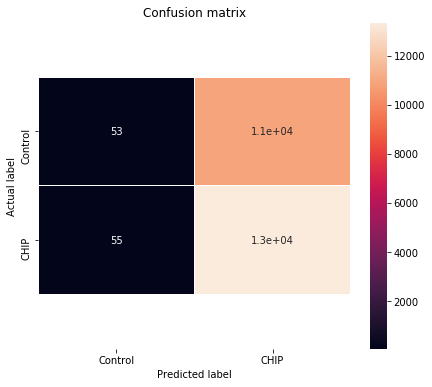

In [44]:
from sklearn.metrics import confusion_matrix # import the confusion matrix function
from sklearn.metrics import accuracy_score, precision_score, recall_score # import the score functions 

y_pred=logreg.predict(X_test) # calculate the predicted values of the model for the test features

cnf_matrix = confusion_matrix(y_test, y_pred) # create a confusion matrix for our actual and predicted values
# create a data frame from the confusion matrix with the column and row names being the class_names
class_names=['Control', 'CHIP'] # names of the binary classes for plotting
cmatrix = pd.DataFrame(cnf_matrix,columns=class_names,index=class_names) 
f, ax = plt.subplots(figsize=(7,6)) # initialise the plots and axes
sns.heatmap(cmatrix, annot=True, linewidths=.5) # plot the confusion matrix as a heatmap
plt.title('Confusion matrix') # add a title
plt.ylabel('Actual label') # add a ylabel
plt.xlabel('Predicted label') # add a xlabel
# adjust the bottom and top of the figure, so we can view all of it
bottom, top = ax.get_ylim()  # get the y axis limits
ax.set_ylim(bottom + 0.5, top - 0.5); # adjust the y axis limits

print("Accuracy:",np.round(accuracy_score(y_test, y_pred),3)) # calculate and print the accuracy score
print("Precision:",np.round(precision_score(y_test, y_pred),3)) # calculate and print the precision score
print("Recall:",np.round(recall_score(y_test, y_pred),3)) # calculate and print the recall score

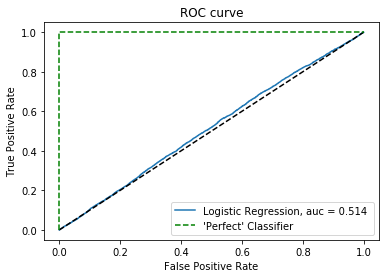

In [45]:
# import the functions to calculate the parameters for the ROC curve and the AUC
from sklearn.metrics import roc_curve, roc_auc_score 
y_pred_proba = logreg.predict_proba(X_test)[::,1] # extract the second column of the model probabilities 
# calculate the false positive and true positive rates as the threshold is varied, we don't use thresholds
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba) # calculate the area under the ROC curve (AUC)
# plot the FPR vs TPR and format label with AUC to 3 decimal places
plt.plot(fpr,tpr,label="Logistic Regression, auc = %0.3f " % auc)
plt.plot([0,1],[0,1],'k--') # plot x = y for comparison
plt.plot([0, 0, 1], [0, 1, 1], 'g--', label="'Perfect' Classifier")
plt.xlabel('False Positive Rate') # add xlabel
plt.ylabel('True Positive Rate') # add ylabel
plt.title('ROC curve') # add title
plt.legend(loc='best'); # add legend

#### SVM

In [47]:
from sklearn.model_selection import train_test_split # import the splitting method from sklearn
from sklearn.datasets import make_blobs 
from sklearn.svm import SVC # import the SVM classifier from sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score # import the score functions

model = SVC(kernel='poly', degree=3, gamma='auto', coef0=5, C=1.) 
model = SVC(decision_function_shape='ovo')
model.fit(X_train, y_train) # fit the X and y data using SVC

y_pred = model.predict(X_test)
print("Accuracy:",np.round(accuracy_score(y_test, y_pred),3)) 
print("Precision:",np.round(precision_score(y_test, y_pred, average = 'micro'),3)) 
print("Recall:",np.round(recall_score(y_test, y_pred, average = 'micro'),3)) 

Accuracy: 0.549
Precision: 0.549
Recall: 0.549
